# Incertidumbre en Redes Neuronales - Regresión

In [0]:
import pandas as pd
import numpy as np
import torch 
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn import Parameter, MSELoss, Sequential, Linear, ReLU, Dropout
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import dropout
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from keras import callbacks, optimizers

Using TensorFlow backend.


In [0]:
# General Parameters
N_INPUT = 1
N_OUTPUT = 1
N_HIDDEN = [75, 50]
LEARNING_RATE = 0.03
EPOCHS = 2500
MC_SAMPLES = 500

### 1. Conjunto de Datos

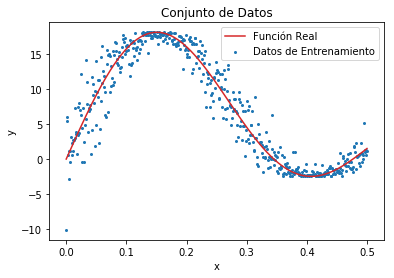

In [0]:
# Generation
def function(x, sigma):
  epsilon = np.random.randn(*x.shape) * sigma
  xr = x + epsilon
  return 3 * xr + 10 * np.sin(2 * np.pi * (xr)) + 10 * np.sin(4 * np.pi * (xr))

class customDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self,idx):
    Xi = self.X[idx]
    yi = self.y[idx]
    return Xi,yi

train_size = 500
noise = 0.02
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

X = np.linspace(0, 0.5, train_size).reshape(-1, 1)
y = function(X, sigma=noise)
y_true = function(X, sigma=0.0)
X_test = np.linspace(-0.5, 1.5, 1000).reshape(-1, 1)

trainDataset = customDataset(X, y)
trainDataLoader = DataLoader(trainDataset, batch_size=train_size)

plt.scatter(X, y, label='Datos de Entrenamiento', s=4)
plt.plot(X, y_true, label='Función Real', color=u'#d62728')
plt.title('Conjunto de Datos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 2. MC Dropout

In [0]:
# Model
p = 0.2
model_mc = Sequential(Linear(N_INPUT, N_HIDDEN[0]),
                   ReLU(),
                   Dropout(p=p),
                   Linear(N_HIDDEN[0], N_HIDDEN[1]),
                   ReLU(),
                   Dropout(p=p),
                   Linear(N_HIDDEN[1], N_OUTPUT))

criterion = MSELoss()
criterion_val = MSELoss(reduction='mean')

#optimizer = optim.Adam(model_mc.parameters(), lr=LEARNING_RATE)
optimizer = optim.SGD(model_mc.parameters(), lr=LEARNING_RATE)
model_mc

Sequential(
  (0): Linear(in_features=1, out_features=75, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=75, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=50, out_features=1, bias=True)
)

In [0]:
# Training
train_loss = []
for epoch in range(EPOCHS):
  temp_train_loss = 0.0
  for i, (X_b, y_b) in enumerate(trainDataLoader):
    optimizer.zero_grad()
    y_pred = model_mc.forward(X_b.float()).reshape_as(y_b)
    loss = criterion(y_pred,y_b.float())
    loss.backward()
    optimizer.step()
    temp_train_loss += loss.item()/len(trainDataLoader)
  if epoch%(1*100) == 0:
    print('Epoch {:3d} | Train Loss : {:5.8f}'.format(epoch+1, temp_train_loss))

Epoch   1 | Train Loss : 106.26302338
Epoch 101 | Train Loss : 29.45414162
Epoch 201 | Train Loss : 18.61543846
Epoch 301 | Train Loss : 18.03784370
Epoch 401 | Train Loss : 13.69671345
Epoch 501 | Train Loss : 11.62048817
Epoch 601 | Train Loss : 9.08068657
Epoch 701 | Train Loss : 10.35802555
Epoch 801 | Train Loss : 10.21489620
Epoch 901 | Train Loss : 10.51426029
Epoch 1001 | Train Loss : 8.20977879
Epoch 1101 | Train Loss : 9.29078007
Epoch 1201 | Train Loss : 6.64153814
Epoch 1301 | Train Loss : 8.74115467
Epoch 1401 | Train Loss : 6.76757002
Epoch 1501 | Train Loss : 7.83121681
Epoch 1601 | Train Loss : 8.43659687
Epoch 1701 | Train Loss : 7.10737467
Epoch 1801 | Train Loss : 5.90399742
Epoch 1901 | Train Loss : 6.53430271
Epoch 2001 | Train Loss : 5.75595808
Epoch 2101 | Train Loss : 6.14534950
Epoch 2201 | Train Loss : 6.28049898
Epoch 2301 | Train Loss : 6.19324589
Epoch 2401 | Train Loss : 5.65529585


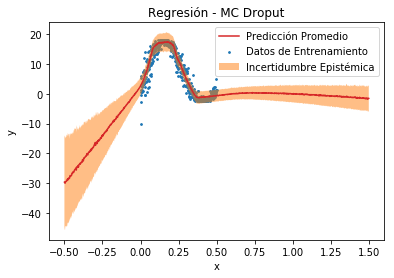

In [0]:
# Evaluation
mc_preds = []
model_mc.train(True)
with torch.no_grad():
  X_tensor_test = torch.FloatTensor(X_test)
  for i in range(MC_SAMPLES):
    y_pred = model_mc.forward(X_tensor_test).detach().numpy()
    mc_preds.append(y_pred) 
  mc_preds = np.hstack(mc_preds)

mc_mean = mc_preds.mean(axis=1)
mc_std = mc_preds.std(axis=1)

plt.figure()
plt.scatter(X, y, label='Datos de Entrenamiento', s=3)
plt.fill_between(X_test.flatten(), mc_mean - 2*mc_std, mc_mean + 2*mc_std, alpha=0.5, label='Incertidumbre Epistémica')
plt.plot(X_test, mc_mean, label='Predicción Promedio', color=u'#d62728')
plt.title('Regresión - MC Droput')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 3. Bayes by Backprop

In [0]:
### BBB Neural Network Model
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tf.distributions.Normal(mu, sigma)
        return kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))
      
def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tf.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

In [0]:
# Training
x_in = Input(shape=(N_INPUT,))
x = DenseVariational(N_HIDDEN[0], kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(N_HIDDEN[1], kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(N_OUTPUT, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)
model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=EPOCHS, verbose=1);

W0630 20:53:36.067218 140660962473856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 20:53:36.069101 140660962473856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 20:53:36.074074 140660962473856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0630 20:53:36.112267 140660962473856 deprecation.py:323] From <ipython-input-7-65e7ea0ca374>:59: Normal.__init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has mo

Epoch 1/2500
500/500 [==============================] - 1s 3ms/step - loss: 392807424.0000 - mean_squared_error: 628.4876
Epoch 2/2500
500/500 [==============================] - 0s 20us/step - loss: 28758476.0000 - mean_squared_error: 46.0113
Epoch 3/2500
500/500 [==============================] - 0s 13us/step - loss: 291816992.0000 - mean_squared_error: 466.9063
Epoch 4/2500
500/500 [==============================] - 0s 12us/step - loss: 74478720.0000 - mean_squared_error: 119.1663
Epoch 5/2500
500/500 [==============================] - 0s 10us/step - loss: 50670144.0000 - mean_squared_error: 81.0731
Epoch 6/2500
500/500 [==============================] - 0s 10us/step - loss: 363991872.0000 - mean_squared_error: 582.3882
Epoch 7/2500
500/500 [==============================] - 0s 11us/step - loss: 73252504.0000 - mean_squared_error: 117.2053
Epoch 8/2500
500/500 [==============================] - 0s 8us/step - loss: 32643252.0000 - mean_squared_error: 52.2304
Epoch 9/2500
500/500 [====

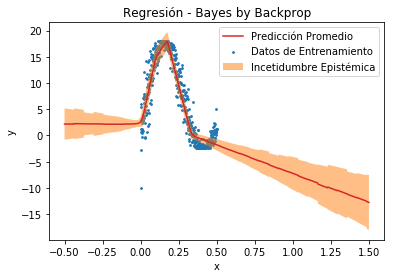

In [0]:
# Evaluation
y_pred_list = []
for i in range(MC_SAMPLES):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

bbb_mean = np.mean(y_preds, axis=1)
bbb_std = np.std(y_preds, axis=1)

plt.plot(X_test, bbb_mean, color=u'#d62728', label='Predicción Promedio');
plt.scatter(X, y, s=3, label='Datos de Entrenamiento')
plt.fill_between(X_test.ravel(), 
                 bbb_mean + 2 * bbb_std, 
                 bbb_mean - 2 * bbb_std, 
                 alpha=0.5, label='Incetidumbre Epistémica')
plt.title('Regresión - Bayes by Backprop')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 4. Comparación de Modelos

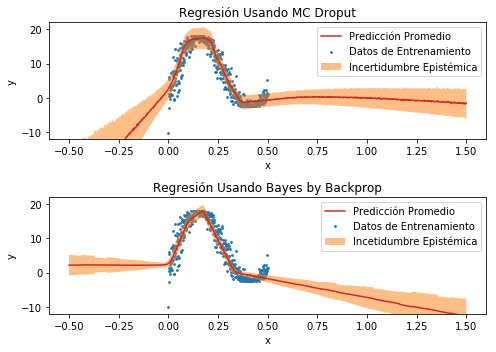

In [0]:
fig = plt.figure(figsize=(7,5))
plt.subplot(2, 1, 1)
plt.scatter(X, y, label='Datos de Entrenamiento', s=3)
plt.fill_between(X_test.flatten(), 
                 mc_mean - 2*mc_std, 
                 mc_mean + 2*mc_std, 
                 alpha=0.5, label='Incertidumbre Epistémica')
plt.plot(X_test, mc_mean, label='Predicción Promedio', color=u'#d62728')
plt.title('Regresión Usando MC Droput')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim([-12, 22])
plt.subplot(2, 1, 2)
plt.plot(X_test, bbb_mean, color=u'#d62728', label='Predicción Promedio');
plt.scatter(X, y, s=3, label='Datos de Entrenamiento')
plt.fill_between(X_test.ravel(), 
                 bbb_mean + 2 * bbb_std, 
                 bbb_mean - 2 * bbb_std, 
                 alpha=0.5, label='Incetidumbre Epistémica')
plt.title('Regresión Usando Bayes by Backprop')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim([-12, 22])
plt.tight_layout()
plt.savefig('uncertainty_regression.png', bbox_inches='tight', dpi=300)
plt.show()